In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from scipy.optimize import least_squares

# Equação IDF para predição
def idf_predict(params, t_r, t_c):
    a, b, c, d = params
    return (a * t_r ** b) / ((t_c + c) ** d)

# Ajusta os parâmetros a, b, c, d via Levenberg-Marquardt
def ajustar_parametros_lm(df):
    td = df['td (min)'].astype(str).str.replace(',', '.', regex=False).astype(float).values
    tr = df['tr'].values
    y_obs = df['y_obs (mm/h)'].values

    def residuals(params, tr, td, y_true):
        return idf_predict(params, tr, td) - y_true

    result = least_squares(
        residuals,
        x0=[500, 0.09, 5, 0.3],
        args=(tr, td, y_obs),
        method='lm',
        max_nfev=1000
    )
    return result.x  # Retorna os parâmetros otimizados

# Calcula R² para cada TR e retorna também o R² médio
def calcular_r2_por_tr(df, params):
    df = df.copy()
    df['td (min)'] = df['td (min)'].astype(str).str.replace(',', '.', regex=False).astype(float)

    r2_por_tr = {}
    for tr_val, grupo in df.groupby('tr'):
        y_true = grupo['y_obs (mm/h)'].values
        t_c = grupo['td (min)'].values
        y_pred = idf_predict(params, tr_val, t_c)
        r2 = r2_score(y_true, y_pred)
        r2_por_tr[f"r2 (TR={tr_val} anos)"] = r2

    r2_medio = np.mean(list(r2_por_tr.values()))
    return r2_por_tr, r2_medio

# Função principal que ajusta, plota e exporta a planilha com resultados
def ajustar_e_plotar(df, nome_arquivo="resultados_idf.xlsx"):
    # Ajustar parâmetros
    params = ajustar_parametros_lm(df)

    # Calcular predições
    df_plot = df.copy()
    df_plot['td (min)'] = df_plot['td (min)'].astype(str).str.replace(',', '.', regex=False).astype(float)
    df_plot['y_pred'] = idf_predict(params, df_plot['tr'].values, df_plot['td (min)'].values)

    # Plotar gráfico por TR e imprimir R²
    r2_dict, r2_medio = calcular_r2_por_tr(df, params)
    for tr_val, grupo in df_plot.groupby('tr'):
        y_true = grupo['y_obs (mm/h)'].values
        y_pred = grupo['y_pred'].values
        r2 = r2_score(y_true, y_pred)

        print(f"R² (TR={tr_val} anos): {r2:.4f}")

        plt.figure(figsize=(8, 5))
        plt.plot(grupo['td (min)'], y_true, 'o-', label='Observado')
        plt.plot(grupo['td (min)'], y_pred, 's--', label='Previsto (IDF)', alpha=0.8)
        plt.xlabel('td (min)')
        plt.ylabel('y (mm/h)')
        plt.title(f'IDF: TR = {tr_val}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Adicionar colunas a, b, c, d para cada linha e reorganizar para Excel
    df_export = df_plot.copy()
    df_export['a'] = params[0]
    df_export['b'] = params[1]
    df_export['c'] = params[2]
    df_export['d'] = params[3]

    colunas_finais = ['td (min)', 'tr', 'y_obs (mm/h)', 'a', 'b', 'c', 'd', 'y_pred']
    df_export = df_export[colunas_finais]

    # Salvar Excel
    df_export.to_excel(nome_arquivo, index=False)

    # Impressão no terminal
    print(f"\n📌 Parâmetros otimizados:\na = {params[0]:.4f}, b = {params[1]:.4f}, c = {params[2]:.4f}, d = {params[3]:.4f}")
    print(f"\n📈 R² médio: {r2_medio:.4f}")
    print(f"\n✅ Planilha salva com colunas detalhadas como: {nome_arquivo}")


R² (TR=2 anos): 0.9136


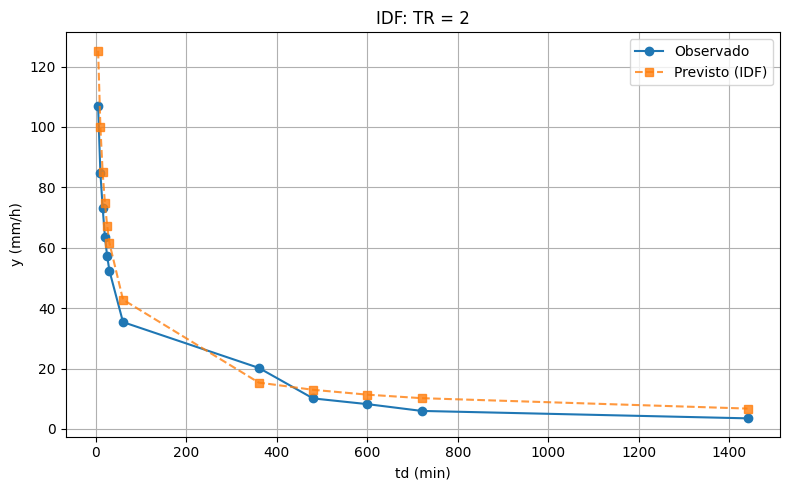

R² (TR=5 anos): 0.9929


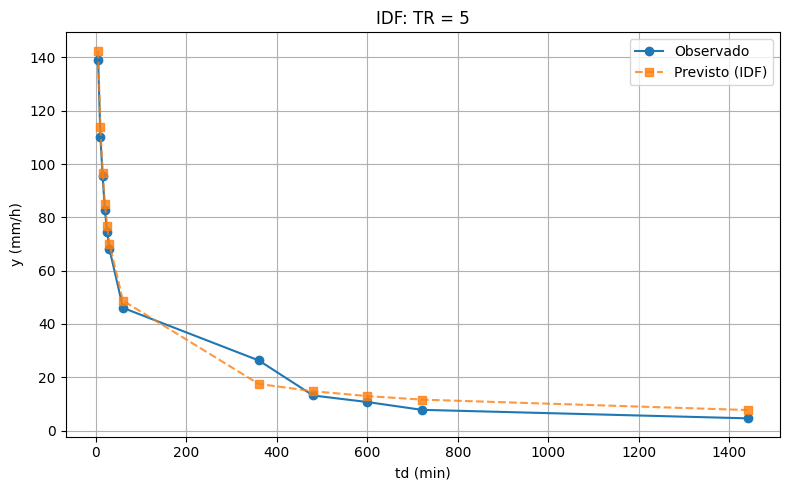

R² (TR=10 anos): 0.9939


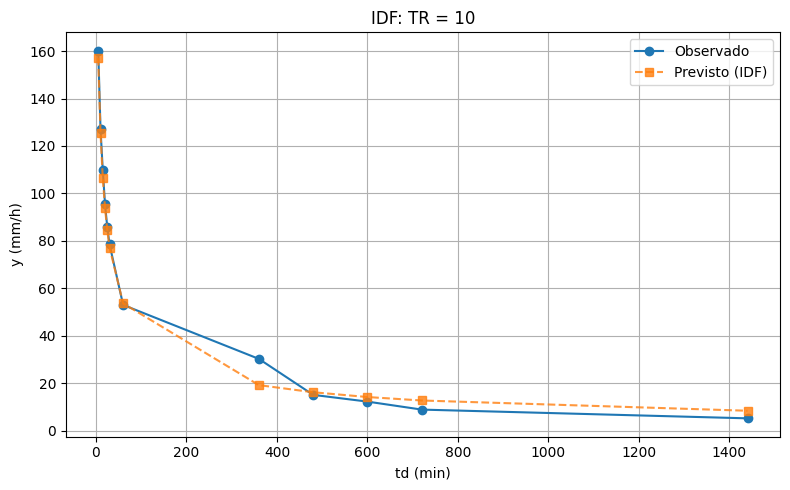

R² (TR=20 anos): 0.9906


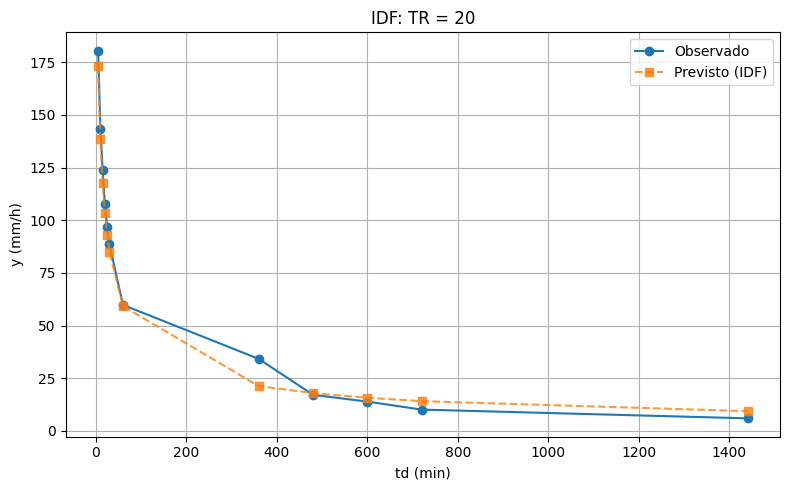

R² (TR=50 anos): 0.9889


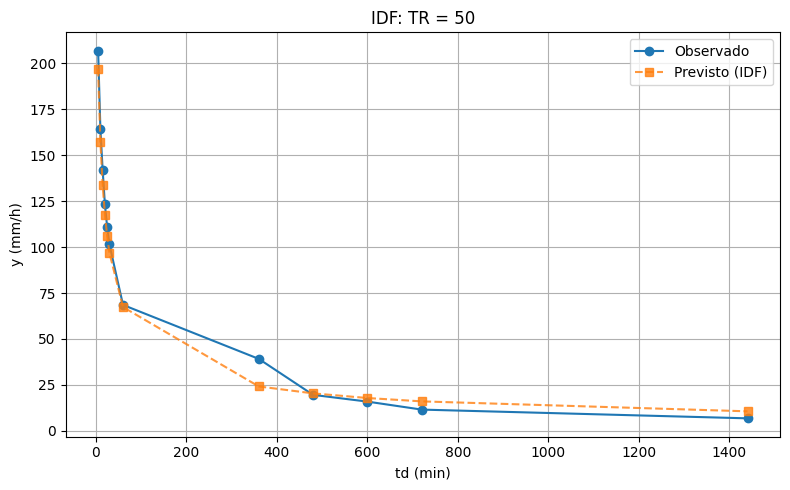

R² (TR=100 anos): 0.9904


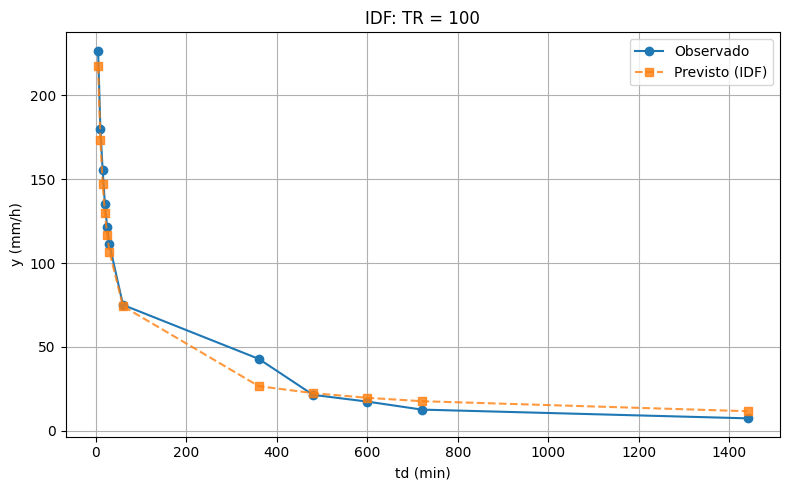

R² (TR=500 anos): 0.9948


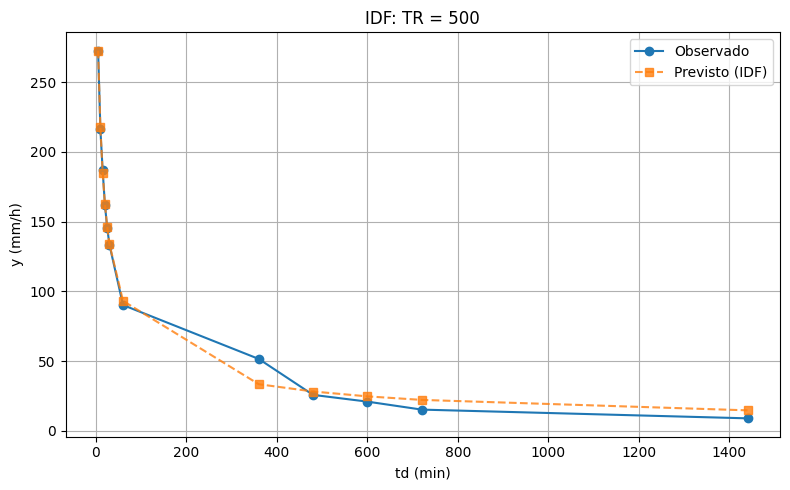

R² (TR=1000 anos): 0.9924


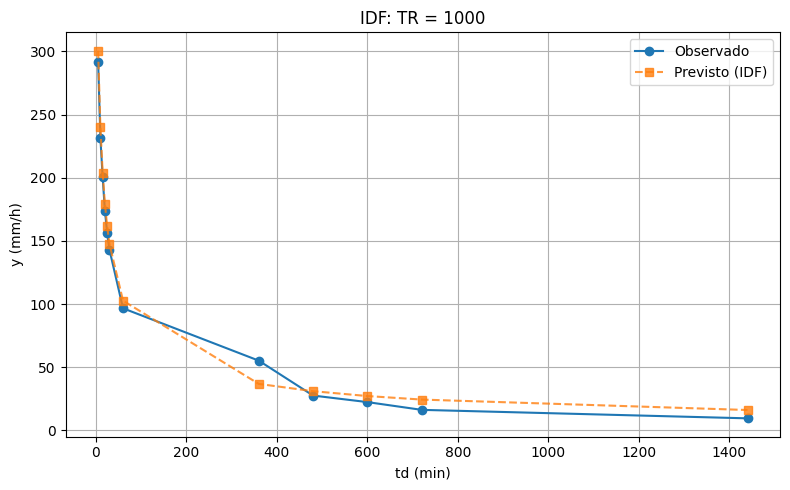


📌 Parâmetros otimizados:
a = 476.6349, b = 0.1408, c = 5.9750, d = 0.5986

📈 R² médio: 0.9822

✅ Planilha salva com colunas detalhadas como: idf_cidadeA.xlsx


In [2]:
df = pd.read_excel("dados_para_idf.xlsx")
ajustar_e_plotar(df, nome_arquivo="idf_cidadeA.xlsx")